In [4]:
import os
import glob
import lsst.eotest.image_utils as imutils
import lsst.eotest.sensor as sensorTest
import lsst.eotest.raft as raft
import matplotlib.pyplot as plt
import numpy as np
import yaml
import sys
sys.path.insert(0, '../')
import ccob_utils as u
import ccob_beam as b
import pickle
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
config_file_beam = '../ccob_beam_recons_config.yaml'
config = u.load_ccob_config(config_file_beam)

In [61]:
#ref_amp_list = [1,4,7,12,13]
ref_amp_list = [13]
for ref_amp in ref_amp_list:
    beam = b.CcobBeam(config_file=config_file)
    beam.recons(ref_slot='11', ref_amp=ref_amp, ref_pix_x=1000,ref_pix_y=256)
    beam.make_image()
    beam.find_max()
    filename = beam.config['led_name']+'_beam_slot'+beam.properties['ref_slot']+'_amp'+str(ref_amp)+\
               '_refx'+str(beam.properties['ref_pix_x'])+'_refy'+str(beam.properties['ref_pix_y'])+'.pkl'
    print('Printing to ',filename)
    beam.save(os.path.join(beam.config['tmp_dir'],filename))
  

red
/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/scan_ccob/red/11*red*********
Printing to  red_beam_slot11_amp13_refx1000_refy256.pkl


In [62]:
my_beam = pickle.load(open(os.path.join(beam.config['tmp_dir'],filename),'rb'))
my_beam.make_image(ncols=3000,nrows=3000)
my_beam.find_max()
print(my_beam.properties)

{'ref_slot': '11', 'ref_amp': 13, 'ref_pix_x': 1000, 'ref_pix_y': 256, 'npix_for_avg': 30, 'ncols': 3000, 'nrows': 3000, 'max_xccob': 286.52484161387127, 'max_yccob': 199.07902634211405, 'max_xarg': 1490, 'max_yarg': 1741}


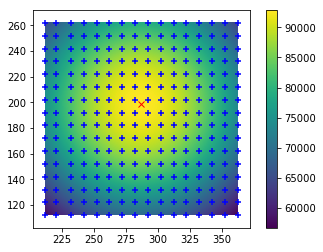

In [63]:
%matplotlib inline
my_beam.plot()

In [64]:
my_file = '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/red/00_CCOB_red_x295.0_y195.0_0000_20180420200617.fits.fz'
config_file_data = '../ccob_config_RTM-006.yaml'
config = u.load_ccob_config(config_file_data)
print(config)

{'led_name': 'red', 'path': '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/red', 'tmp_dir': '/home/combet/tmp_new/', 'eo_data_path': '/gpfs/slac/lsst/fs1/g/data/jobHarness/jh_archive-test/LCA-11021_RTM/LCA-11021_RTM-006-Dev/5867D/collect_raft_results/v0/38904', 'xpos': '295.0', 'ypos': '195.0', 'current': '*', 'exp_time': '*', 'slot': '*'}


In [65]:
slot_names=['00','01','02','10','11','12','20','21','22']

slot='11'
file_list=sorted(u.find_files(config, slot=slot))
print(file_list)

mean_slot_file = slot+'_mean_ccob_image.fits'
imutils.fits_mean_file(file_list, os.path.join(config['tmp_dir'],mean_slot_file))


#fits_file = file_list[0]
fits_file = os.path.join(config['tmp_dir'],mean_slot_file)
gains_dict={}
ccd_dict={}

bias_frames = glob.glob(os.path.join(config['path'], slot+'_bias*'))
mean_bias_file = slot+'_mean_bias_image_RTM-006_new.fits'
#imutils.fits_mean_file(bias_frames, os.path.join(config['tmp_dir'],mean_bias_file))
ccd_dict = sensorTest.MaskedCCD(fits_file, bias_frame=os.path.join(config['tmp_dir'],mean_bias_file))
eotest_results_file = os.path.join(config['eo_data_path'], '{}_eotest_results.fits'.format(ccd_dict.md('LSST_NUM')))
gains_dict = u.gains(eotest_results_file)

/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/red/11*red*****295.0*195.0*
['/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/red/11_CCOB_red_x295.0_y195.0_0000_20180420200541.fits.fz', '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/red/11_CCOB_red_x295.0_y195.0_0000_20180420200550.fits.fz', '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/red/11_CCOB_red_x295.0_y195.0_0000_20180420200559.fits.fz', '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/red/11_CCOB_red_x295.0_y195.0_0000_20180420200608.fits.fz', '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/red/11_CCOB_red_x295.0_y195.0_0000_20180420200617.fits.fz', '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/red/11_CCOB_red_x295.0_y195.0_0000_20180420200626.fits.fz', '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/red/11_CCOB_red_x295.0_y195.0_0000_20180420200635.fits.fz', '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/ccob/red/11_CCOB_red_x295.0_y195.0_0000_2018042020064

In [66]:
mosaic, amp_coord = u.make_ccd_2d_array(fits_file, gains=gains_dict)
ref_pix = u.pix_coord_in_mosaic(amp_coord, ref_amp_list[0], 256, 1000)

xpos_ccob = 295.0
ypos_ccob = 195.0
delta_x = ypos_ccob - my_beam.properties['max_yccob']
delta_y = xpos_ccob - my_beam.properties['max_xccob']
delta_x_pix = int(delta_x/0.01)
delta_y_pix = int(delta_y/0.01)

print('deplacement in mm: dx=%0.2f dy=%0.2f'%(delta_x, delta_y))
print('deplacement in pixels: dx=%i dy=%i'%(delta_x_pix, delta_y_pix))

geom_center_pos=(ref_pix[0]+delta_x_pix, ref_pix[1]+delta_y_pix)
geom_center_pos

deplacement in mm: dx=-4.08 dy=8.48
deplacement in pixels: dx=-407 dy=847


(1897, 1847)

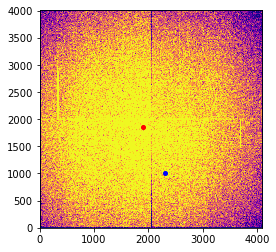

In [67]:
plt.imshow(mosaic, origin='lower', vmin=63000, vmax=65000, cmap='plasma')
plt.plot([ref_pix[0]], [ref_pix[1]], marker='o', markersize=4, color='blue')
plt.plot([geom_center_pos[0]], [geom_center_pos[1]], marker='o', markersize=4, color='red')

In [68]:
# distance from beam center to ccd edges in mm
dist_to_left = geom_center_pos[0]*0.01
dist_to_bottom = geom_center_pos[1]*0.01
dist_to_right = (mosaic.shape[1] - geom_center_pos[0])*0.01
dist_to_top = (mosaic.shape[0] - geom_center_pos[1])*0.01
print(dist_to_left,dist_to_bottom,dist_to_right,dist_to_top)
print(dist_to_left+dist_to_right, dist_to_bottom+dist_to_top)

18.97 18.47 21.990000000000002 21.57
40.96 40.04


In [69]:
bbox=(my_beam.properties['max_xccob']-dist_to_left,
      my_beam.properties['max_xccob']+dist_to_right,
      my_beam.properties['max_yccob']-dist_to_bottom,
      my_beam.properties['max_yccob']+dist_to_top)

In [70]:
xarr2 = np.linspace(bbox[0],bbox[1],mosaic.shape[1])
yarr2 = np.linspace(bbox[2],bbox[3],mosaic.shape[0])
tmp = my_beam.beam_image['f_interp'](xarr2, yarr2)

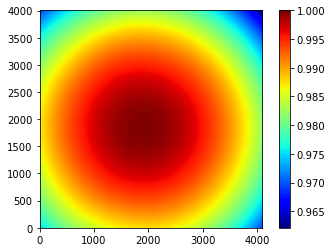

In [71]:
plt.imshow(tmp/np.max(tmp.flatten()), origin='lower', cmap='jet')
plt.colorbar()

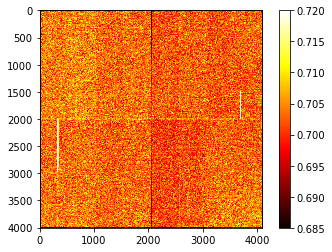

In [78]:
res=mosaic/tmp
plt.imshow(res, vmin=0.685, vmax=0.72, cmap='hot')
plt.colorbar()